**Author: Rahul Narang**

Stock Market Prediction Using Numarical and Textual Analysis

Here, I have made a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import inflect
from collections import OrderedDict
os.chdir("/content/drive/My Drive/grip")
!ls

BSME.csv  india-news-headlines.csv


In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')

In [ ]:
stock_df = pd.read_csv("BSME.csv")
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,16-10-2019,38637.05078,38666.37891,38416.67188,38598.98828,38598.98828,27500.0
1,17-10-2019,38647.44141,39104.69141,38557.42969,39052.05859,39052.05859,47100.0
2,18-10-2019,39087.82813,39361.05859,38963.60156,39298.37891,39298.37891,42400.0
3,22-10-2019,39233.39844,39426.46875,38924.85156,38963.83984,38963.83984,54500.0
4,23-10-2019,39063.83984,39196.67188,38866.07813,39058.82813,39058.82813,41000.0


In [ ]:
print("First Date "+stock_df.Date.iloc[0])
print("Last Date "+stock_df.Date.iloc[-1])

First Date 16-10-2019
Last Date 16-10-2020


**Working on the News Headline Dataset**

In [ ]:
news_dataset = pd.read_csv('india-news-headlines.csv')
news_dataset.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 78.4+ MB


In [ ]:
news_dataset = news_dataset.drop(['headline_category'],axis=1)
news_dataset.head()

,publish_date,headline_text
0,20010102,Status quo will not be disturbed at Ayodhya; s...
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic


In [ ]:
news_dataset['publish_date'] = pd.to_datetime(news_dataset['publish_date'],format= '%Y%m%d')

In [ ]:
news_dataset.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


In [ ]:
news_dataset.publish_date[0]

Timestamp('2001-01-02 00:00:00')

In [ ]:
news_dataset.publish_date.iloc[-1]

Timestamp('2020-12-31 00:00:00')

In [ ]:
#choosing news headlines b/w 16-10-2019 and 16-10-2020
news_df = news_dataset.loc[(news_dataset['publish_date'] > '2019-10-16') & (news_dataset['publish_date'] <= '2020-10-16')]
news_df.head()

,publish_date,headline_text
3203527,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...
3203528,2019-10-17,Mumbai men gear up for Karva Chauth; along wit...
3203529,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...
3203530,2019-10-17,Srinidhi Shetty: Vikram; AR Rahman and Ajay......
3203531,2019-10-17,Neha Dhupia: I'm confused whether to fast for ...


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182637 entries, 3203527 to 3386163
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   publish_date   182637 non-null  datetime64[ns]
 1   headline_text  182637 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 4.2+ MB


In [ ]:
news_df.reset_index(inplace = True, drop = True)
news_df.head()

,publish_date,headline_text
0,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...
1,2019-10-17,Mumbai men gear up for Karva Chauth; along wit...
2,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...
3,2019-10-17,Srinidhi Shetty: Vikram; AR Rahman and Ajay......
4,2019-10-17,Neha Dhupia: I'm confused whether to fast for ...


In [ ]:
news_df['Polarity'] = np.nan
news_df['Subjectivity'] = np.nan

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182637 entries, 0 to 182636
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   publish_date   182637 non-null  datetime64[ns]
 1   headline_text  182637 non-null  object        
 2   Polarity       0 non-null       float64       
 3   Subjectivity   0 non-null       float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 5.6+ MB


In [ ]:
for i in range(news_df.shape[0]):
  if i==100000:
    print('Half Done')
  temp = TextBlob(news_df['headline_text'].loc[i]).sentiment
  news_df['Subjectivity'].loc[i] = temp.subjectivity
  news_df['Polarity'].loc[i] = temp.polarity

Half Done


In [ ]:
news_df.head()

,publish_date,headline_text,Polarity,Subjectivity
0,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000,0.00
1,2019-10-17,Mumbai men gear up for Karva Chauth; along wit...,0.000,0.00
2,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000,0.00
3,2019-10-17,Srinidhi Shetty: Vikram; AR Rahman and Ajay......,0.375,0.75
4,2019-10-17,Neha Dhupia: I'm confused whether to fast for ...,-0.100,0.65


In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
news_df['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_df['headline_text']]
news_df['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_df['headline_text']]
news_df['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_df['headline_text']]
news_df['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_df['headline_text']]

,publish_date,headline_text,Polarity,Subjectivity,Compound,Negative,Neutral,Positive
0,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000000,0.000000,0.0000,0.000,1.000,0.000
1,2019-10-17,Mumbai men gear up for Karva Chauth; along wit...,0.000000,0.000000,0.0000,0.000,1.000,0.000
2,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000000,0.000000,0.0000,0.000,1.000,0.000
3,2019-10-17,Srinidhi Shetty: Vikram; AR Rahman and Ajay......,0.375000,0.750000,0.3400,0.000,0.821,0.179
4,2019-10-17,Neha Dhupia: I'm confused whether to fast for ...,-0.100000,0.650000,-0.3182,0.173,0.827,0.000
...,...,...,...,...,...,...,...,...
182632,2020-10-16,M Sivasankar gets Kerala HC respite in gold case,0.000000,0.000000,0.0000,0.000,1.000,0.000
182633,2020-10-16,Nagpur: Woman; daughter end life over domestic...,0.000000,0.100000,0.0000,0.000,1.000,0.000
182634,2020-10-16,Vidarbha reports increase in new Covid cases; ...,0.136364,0.454545,0.3182,0.000,0.777,0.223
182635,2020-10-16,Bihar elections; Phase I: 319 in poll fray hav...,-0.400000,0.550000,-0.5267,0.254,0.746,0.000


In [ ]:
news_df.head()

,publish_date,headline_text,Polarity,Subjectivity,Compound,Negative,Neutral,Positive
0,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000,0.00,0.0000,0.000,1.000,0.000
1,2019-10-17,Mumbai men gear up for Karva Chauth; along wit...,0.000,0.00,0.0000,0.000,1.000,0.000
2,2019-10-17,Dayal Padmanabhan dedicates Ranganayaki to Kan...,0.000,0.00,0.0000,0.000,1.000,0.000
3,2019-10-17,Srinidhi Shetty: Vikram; AR Rahman and Ajay......,0.375,0.75,0.3400,0.000,0.821,0.179
4,2019-10-17,Neha Dhupia: I'm confused whether to fast for ...,-0.100,0.65,-0.3182,0.173,0.827,0.000


In [ ]:
date_list = list(news_df.publish_date.unique())
news_df_final = pd.DataFrame(columns=['date','polarity_mean','subjectivity_mean','Compound','Negative','Neutral','Positive'])
for date in date_list:
  temp = news_df.loc[news_df.publish_date == date]
  pol = temp.Polarity.mean()
  sub = temp.Subjectivity.mean()
  com = temp.Compound.mean()
  neg = temp.Negative.mean()
  neu = temp.Neutral.mean()
  pos = temp.Positive.mean()

  news_df_final = news_df_final.append({'date': date,'polarity_mean': pol,'subjectivity_mean': sub,'Compound':com,'Negative':neg,'Neutral':neu,'Positive':pos}, ignore_index=True)


In [ ]:
news_df_final.head()

,date,polarity_mean,subjectivity_mean,Compound,Negative,Neutral,Positive
0,2019-10-17,0.030465,0.195995,-0.064499,0.116486,0.811782,0.071736
1,2019-10-18,0.018567,0.198447,-0.040108,0.108986,0.807801,0.083217
2,2019-10-19,0.042482,0.177297,-0.044446,0.109154,0.815824,0.075026
3,2019-10-20,0.020826,0.176952,-0.049552,0.105781,0.816647,0.077570
4,2019-10-21,0.028942,0.168246,-0.061851,0.107394,0.824581,0.068014


Histogram of Polarity,Subjectivity,Negative,Neutral And Positive for each date

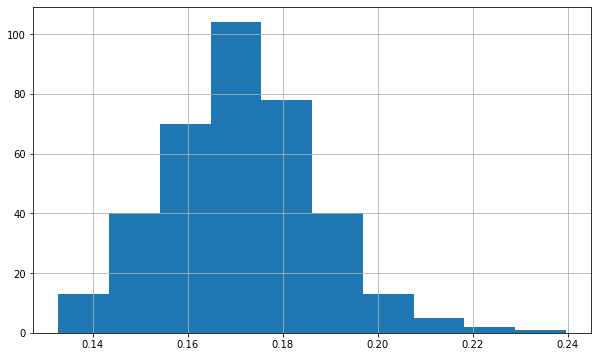

In [284]:
#graph of subjectivity
plt.figure(figsize = (10,6))
news_df_final.subjectivity_mean.hist()

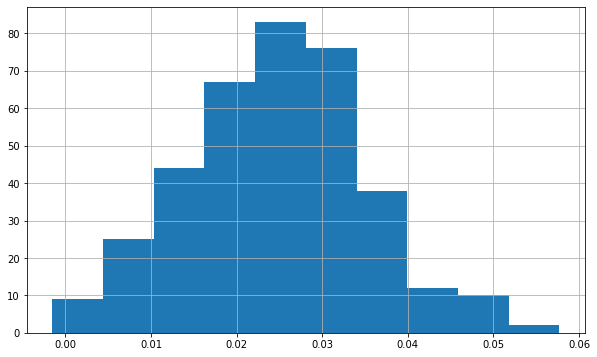

In [285]:
plt.figure(figsize = (10,6))
news_df_final.polarity_mean.hist()

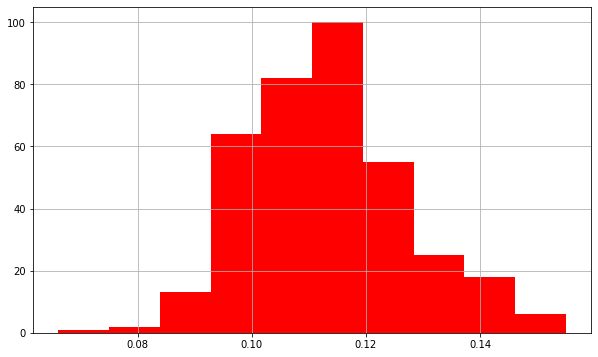

In [282]:
plt.figure(figsize = (10,6))
news_df_final.Negative.hist(color='Red')

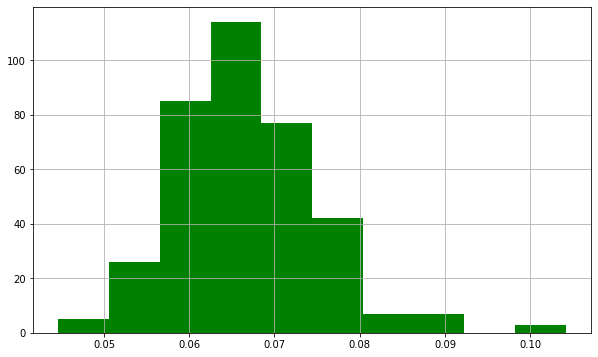

In [283]:
plt.figure(figsize = (10,6))
news_df_final.Positive.hist(color='green')

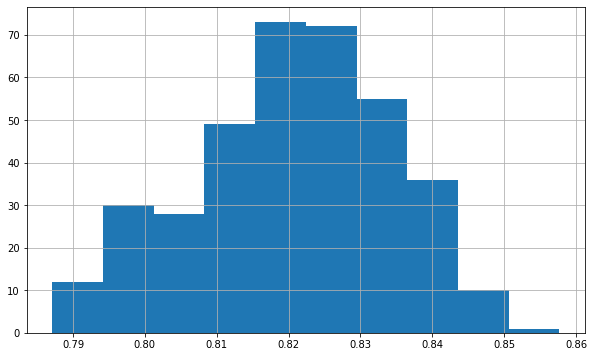

In [281]:
plt.figure(figsize = (10,6))
news_df_final.Neutral.hist()

**Working on the Stock Dataset**

In [ ]:
stock_df = pd.read_csv("BSME.csv")
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,16-10-2019,38637.05078,38666.37891,38416.67188,38598.98828,38598.98828,27500.0
1,17-10-2019,38647.44141,39104.69141,38557.42969,39052.05859,39052.05859,47100.0
2,18-10-2019,39087.82813,39361.05859,38963.60156,39298.37891,39298.37891,42400.0
3,22-10-2019,39233.39844,39426.46875,38924.85156,38963.83984,38963.83984,54500.0
4,23-10-2019,39063.83984,39196.67188,38866.07813,39058.82813,39058.82813,41000.0


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       249 non-null    float64
 2   High       249 non-null    float64
 3   Low        249 non-null    float64
 4   Close      249 non-null    float64
 5   Adj Close  249 non-null    float64
 6   Volume     249 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


In [ ]:
stock_df['Date'] = pd.to_datetime(stock_df.Date,format='%d-%m-%Y')
stock_df.index = stock_df['Date']
stock_df.dropna(subset=['Close'],inplace=True)

Text(0.5, 1.0, 'Close Price history')

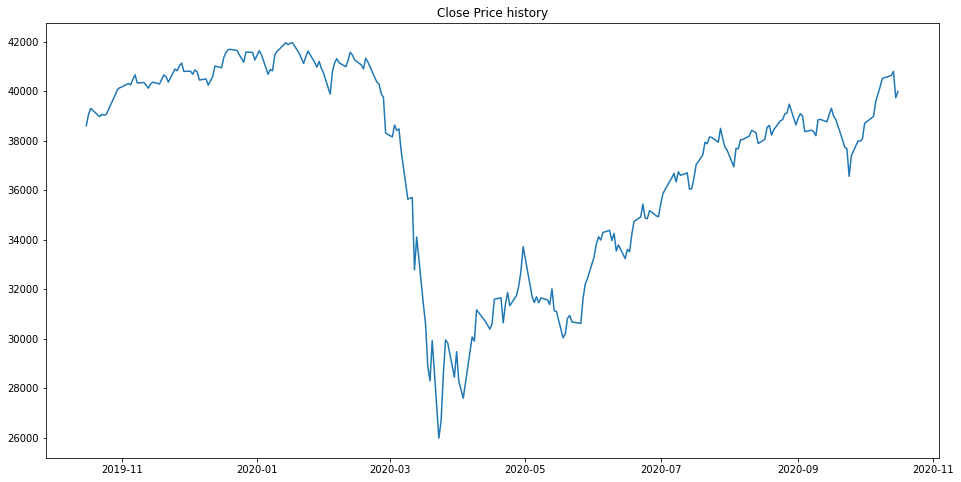

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(stock_df['Close'])
plt.title('Close Price history')

In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2019-10-16 to 2020-10-16
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       249 non-null    datetime64[ns]
 1   Open       249 non-null    float64       
 2   High       249 non-null    float64       
 3   Low        249 non-null    float64       
 4   Close      249 non-null    float64       
 5   Adj Close  249 non-null    float64       
 6   Volume     249 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 15.6 KB


In [ ]:
closing_data = pd.read_csv('BSME.csv', usecols=[5])
closing_data.dropna(inplace=True)
closing_data = closing_data.values
closing_data = closing_data.astype('float32')

In [ ]:
def create_dataset(closing_data, look_back=1):
	dataX, dataY = [], []
	for i in range(len(closing_data)-look_back-1):
		a = closing_data[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(closing_data[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
closing_data = scaler.fit_transform(closing_data)

In [ ]:
train_size = int(len(closing_data) * 0.70)
test_size = len(closing_data) - train_size
train, test = closing_data[0:train_size,:], closing_data[train_size:len(closing_data),:]

In [ ]:
look_back = 3
xtrain, ytrain = create_dataset(train, look_back)
xtest, ytest = create_dataset(test, look_back)
#reshape input to be [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [ ]:
print(xtrain[0])

[[0.790022  ]
 [0.81838953]
 [0.8338121 ]]


In [ ]:
print(ytrain[0])

0.8128661


In [ ]:
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, epochs=250, batch_size=1, verbose=1)

Epoch 1/250
170/170 [==============================] - 2s 2ms/step - loss: 0.5295
Epoch 2/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 3/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 4/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 5/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 6/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 7/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 8/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 9/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 10/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 11/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/250
170/170 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 13/250


In [ ]:
# make predictions
train_predict = model.predict(xtrain)
test_predict = model.predict(xtest)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
ytrain = scaler.inverse_transform([ytrain])
test_predict = scaler.inverse_transform(test_predict)
ytest = scaler.inverse_transform([ytest])

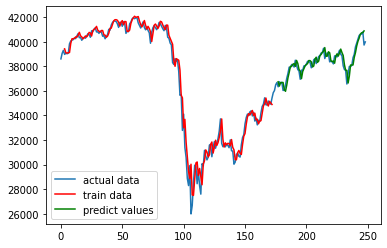

In [286]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(closing_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
test_predict_plot = np.empty_like(closing_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(closing_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(closing_data),label='actual data')
plt.plot(train_predict_plot,color='red',label='train data')
plt.plot(test_predict_plot,color='green',label='predict values')
plt.legend()
plt.show()

In [ ]:
train_score = math.sqrt(mean_squared_error(ytrain[0], train_predict[:,0]))
print("Root mean square error (train score) = ",train_score)
test_score = math.sqrt(mean_squared_error(ytest[0], test_predict[:,0]))
print("Root mean square error (test score) = ",test_score)

Root mean square error (train score) =  708.944067643075
Root mean square error (test score) =  413.53234175151204


**Creating a Hybrid Model**

In [302]:
stock_df.reset_index(inplace = True, drop = True)
news_df_final=news_df_final.rename(columns={'date':'Date'})
X = pd.merge(news_df_final, stock_df[['Date','Close']], on="Date")
X = X.drop(['Date'],axis=1)

In [307]:
X

,polarity_mean,subjectivity_mean,Compound,Negative,Neutral,Positive,Close
0,0.030465,0.195995,-0.064499,0.116486,0.811782,0.071736,39052.05859
1,0.018567,0.198447,-0.040108,0.108986,0.807801,0.083217,39298.37891
2,0.016961,0.201205,-0.074537,0.121936,0.809279,0.068790,38963.83984
3,0.023304,0.189130,-0.055233,0.111150,0.813864,0.074982,39058.82813
4,0.032672,0.197599,-0.050391,0.103538,0.828697,0.067763,39020.39063
...,...,...,...,...,...,...,...
243,0.025472,0.159748,-0.104520,0.124778,0.821106,0.054116,40593.80078
244,0.026397,0.152828,-0.095505,0.113124,0.836529,0.050353,40625.51172
245,0.005641,0.156015,-0.075716,0.111814,0.821178,0.067020,40794.73828
246,0.009740,0.152804,-0.074628,0.104132,0.841110,0.054758,39728.41016


In [308]:
y = X['Close']
y.shape
X = X.drop(['Close'],axis=1)

In [309]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(198, 6)

In [310]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [320]:
for i in range(10):
  print("Actual Value: "+str(y_test.iloc[i])+" Predicted Value: "+str(prediction[i]))
print("Mean Absolute error (Random Forest Regressor) =",mean_absolute_error(prediction,y_test))

Actual Value: 39982.98047 Predicted Value: 37165.99011889998
Actual Value: 35171.26953 Predicted Value: 38706.81074209997
Actual Value: 41141.85156 Predicted Value: 41312.75539079998
Actual Value: 33825.53125 Predicted Value: 34200.51406249999
Actual Value: 30609.30078 Predicted Value: 35004.211856799986
Actual Value: 40789.37891 Predicted Value: 40540.730625100005
Actual Value: 41461.26172 Predicted Value: 38572.8482415
Actual Value: 33228.80078 Predicted Value: 37801.83822289997
Actual Value: 38357.17969 Predicted Value: 37354.432716499985
Actual Value: 39467.30859 Predicted Value: 36316.988321499986
Mean Absolute error (Random Forest Regressor) = 2235.186188693998
